In [1]:
! pip install pytorch-lightning==2.0.1 --quiet
! pip install lightning-bolts --quiet
! pip install matplotlib --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning-bolts 0.7.0 requires pytorch-lightning<2.0.0,>1.7.0, but you have pytorch-lightning 2.0.1 which is incompatible.


In [2]:
! pip install pandas --quiet
! pip install seaborn --quiet

In [3]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F

from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import seaborn as sn
from pytorch_lightning.callbacks import LearningRateMonitor
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# 1- Building blocks using RESNET18

In [4]:
class BasicBlockEnc(nn.Module):

  def __init__(self,in_planes,stride=1):
    super().__init__()

    planes     = in_planes * stride
    self.conv1 = nn.Conv2d(in_planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn1   = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn2   = nn.BatchNorm2d(planes)

    if stride  == 1:
      self.shortcut = nn.Sequential()
    else:
      self.shortcut = nn.Sequential( # have to match the dimension to add later
          nn.Conv2d(in_planes,planes,kernel_size=1,stride=stride,bias=False),
          nn.BatchNorm2d(planes)
      )

  def forward(self,x):

    out = torch.relu(self.bn1(self.conv1(x)))
    #print(out.shape)
    out = self.bn2(self.conv2(out))
    #print(out.shape)
    #print(self.shortcut(x).shape)
    out += self.shortcut(x)
    #print(out.shape)
    out = torch.relu(out)
    #print(out.shape)
    return out

class ResNet18Enc(nn.Module):
  def __init__(self,z_dim):

    super().__init__()
    num_Blocks     = [2,2,2,2] # 4 layers with 2 basic blocks each
    self.in_planes = 64
    self.z_dim = z_dim

    # initial convolution layers
    self.conv1  = nn.Conv2d(4,64,kernel_size=3,stride=2,padding=1,bias=False)
    self.bn1    = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(BasicBlockEnc,64 ,num_Blocks[0],stride=1)
    self.layer2 = self._make_layer(BasicBlockEnc,128,num_Blocks[1],stride=2)
    self.layer3 = self._make_layer(BasicBlockEnc,256,num_Blocks[2],stride=2)
    self.layer4 = self._make_layer(BasicBlockEnc,512,num_Blocks[3],stride=2)

    self.linear_mu     = nn.Linear(512,z_dim)
    self.linear_logvar = nn.Linear(512,z_dim)

  def _make_layer(self,BasicBlockEnc,planes,num_Blocks,stride):
    strides = [stride] + [1]*(num_Blocks-1)
    #print(strides)
    layers = []
    for stride in strides:
      layers += [BasicBlockEnc(self.in_planes,stride)]
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self,x,y):

    y = F.one_hot(y,32).unsqueeze(1).unsqueeze(2) #32,1,1,32
    y = torch.ones((x.size(0),1,32,32)).to('cuda') * y  # 32,1,32,32
    x = torch.cat((x,y),dim=1) # 32,4, 32, 32
    x = torch.relu(self.bn1(self.conv1(x)))
    #print(x.shape)
    x = self.layer1(x)
    #print(x.shape)
    x = self.layer2(x)
    #print(x.shape)
    x = self.layer3(x)
    #print(x.shape)
    x = self.layer4(x)
    #print(x.shape)
    x = F.adaptive_avg_pool2d(x,1)
    #print(x.shape)
    x = x.view(x.size(0),-1)
    mu = self.linear_mu(x)
    logvar = self.linear_logvar(x)
    return mu,logvar

class BasicBlockDec(nn.Module):
  def __init__(self,in_planes,stride=1):
    super().__init__()

    planes = int(in_planes/stride)
    self.conv2 = nn.Conv2d(in_planes,in_planes,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn2 = nn.BatchNorm2d(in_planes)

    if stride == 1:
      self.conv1 = nn.Conv2d(in_planes,in_planes,kernel_size=3,padding=1,stride=1,bias=False)
      self.bn1 = nn.BatchNorm2d(planes)
      self.shortcut = nn.Sequential()
    else:
      #self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride) # 512 to 256
      self.conv1 = nn.ConvTranspose2d(in_planes, planes,kernel_size=2, stride=2)
      self.bn1   = nn.BatchNorm2d(planes)
      self.shortcut = nn.Sequential(
          nn.ConvTranspose2d(in_planes, planes,kernel_size=2, stride=2),
          nn.BatchNorm2d(planes)
    )

  def forward(self,x):
    out = torch.relu(self.bn2(self.conv2(x)))
    #print(out.shape)
    out = self.bn1(self.conv1(out))
    #print(out.shape)
    #print(self.shortcut(x).shape)
    out += self.shortcut(x)
    #print(out.shape)
    out = torch.relu(out)
    return out

class ResNet18Dec(nn.Module):
  def __init__(self,z_dim):
    super().__init__()
    self.in_planes = 512
    num_Blocks=[2,2,2,2]

    self.dec_linear = nn.Linear(z_dim + 10,512)
    self.conv2d_t1 = nn.ConvTranspose2d(512, 512, kernel_size=4)
    self.conv2d_out = nn.Conv2d(64, 3, kernel_size=1)

    self.layer4 = self._make_layer(BasicBlockDec,256,num_Blocks[3],stride=2)
    self.layer3 = self._make_layer(BasicBlockDec,128,num_Blocks[2],stride=2)
    self.layer2 = self._make_layer(BasicBlockDec,64,num_Blocks[1],stride=2)
    self.layer1 = self._make_layer(BasicBlockDec,64,num_Blocks[0],stride=1)


  def _make_layer(self,BasicBlockDec, planes, num_Blocks, stride):
    strides = [stride] + [1] * (num_Blocks-1)
    layers = []
    for stride in strides:
      layers += [BasicBlockDec(self.in_planes,stride)]
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self,z,y):

    y = F.one_hot(y,num_classes=10)
    z = torch.cat((z,y), dim = 1) # 512 + 10 = 522
    x = self.dec_linear(z)
    x = x.view(z.size(0),512,1,1)
    #x = F.interpolate(x,scale_factor=4)
    x = self.conv2d_t1(x)
    x = self.layer4(x)
    #print(x.shape)
    x = self.layer3(x)
    #print(x.shape)
    x = self.layer2(x)
    #print(x.shape)
    x = self.layer1(x)
    #print(x.shape)
    x = self.conv2d_out(x)
    #print(x.shape)
    x = torch.sigmoid(x)
    #print(x.shape)
    return x

# 2 - VAE

In [5]:
class VAE(pl.LightningModule):
  def __init__(self,latent_dim=512):

    super().__init__()

    self.save_hyperparameters()
    self.log_scale = nn.Parameter(torch.Tensor([0.0]))
    self.encoder = ResNet18Enc(z_dim=latent_dim)
    self.decoder = ResNet18Dec(z_dim=latent_dim)

    # classifier head layers
    self.chConv1 = nn.Conv2d(3,64,3)
    self.chout   = nn.Linear(64*30*30,10)
    # classifier loss
    self.bce_loss = nn.BCELoss(reduction = 'none')


  def multilabel_classifier(self,x_hat):
    x_hat_class = F.relu(self.chConv1(x_hat))
    batch_size = x_hat_class.shape[0]
    x_hat_class = x_hat_class.view(batch_size,-1)
    x_hat_class = F.sigmoid(self.chout(x_hat_class))
    return x_hat_class


  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=1e-4)
    scheduler = OneCycleLR(
            optimizer,
            max_lr= 1E-2,
            pct_start = 5/self.trainer.max_epochs,
            epochs=self.trainer.max_epochs,
            steps_per_epoch=len(train_dataloader),
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        )
    return {
         "optimizer": optimizer,
         "lr_scheduler": {"scheduler": scheduler, "interval": "step"},
        }
    #return torch.optim.Adam(self.parameters(), lr=1e-3)

  def kl_divergence(self,z,mu,std):

    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    kl = (log_qzx - log_pz)
    kl = kl.sum(-1)
    return kl

  def gaussian_likelihood(self,mean,logscale,sample):
    scale   = torch.exp(logscale)
    dist    = torch.distributions.Normal(mean,scale)
    log_pxz = dist.log_prob(sample)

    return log_pxz.sum(dim=(1,2,3))

  def mutli_label_loss(self,x_multilabel,y_combo_one_hot):
    ml_loss = self.bce_loss(x_multilabel,y_combo_one_hot).sum(dim=1)
    return ml_loss

  def forward(self,x,y):

      print(f"input shape {x.shape}")
      print(f"y shape {y.shape}")
      mu,log_var = self.encoder(x,y)
      std = torch.exp(log_var/2)
      q = torch.distributions.Normal(mu,std)
      z = q.rsample()
      print(f"z shape {z.shape}")
      x_hat = self.decoder(z,y)
      print(f"output shape {x_hat.shape}")
      return mu,log_var,std,z,x_hat

  def training_epoch_end(self,outputs):
      loss = torch.stack([x['loss'] for x in outputs]).mean()

      print("****Training****")
      print(f'Epoch {self.current_epoch}: Train loss {loss}')

  def validation_epoch_end(self,outputs):
      loss = torch.stack([x for x in outputs]).mean()

      print("****Validation****")
      print(f'Epoch {self.current_epoch}: Validation loss {loss}')

  def training_epoch_end(self,outputs):
      loss = torch.stack([x['loss'] for x in outputs]).mean()

      print("****Training****")
      print(f'Epoch {self.current_epoch}: Train loss {loss}')
        
  def validation_step(self,batch,batch_idx):

        x, y, y_changed = batch['image'],batch['correct_label'],batch['changed_label']

        mu,log_var = self.encoder(x,y_changed)
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()
        x_hat = self.decoder(z,y_changed)

        # multi label classifier
        x_multilabel = self.multilabel_classifier(x_hat)

        # vae loss
        recon_loss = self.gaussian_likelihood(x_hat,self.log_scale,x)
        kl = self.kl_divergence(z,mu,std)
        elbo = kl - recon_loss

        # classifier loss
        y_combo = torch.logical_or(F.one_hot(y, num_classes = 10), F.one_hot(y_changed, num_classes = 10)).float()
        ml_loss = self.mutli_label_loss(x_multilabel,y_combo)

        # weight loss
        total_loss = (1 * ml_loss) + (0.01 * elbo)
        total_loss = total_loss.mean()

        return total_loss

  def training_step(self,batch,batch_idx):

    #x, y = batch
    x, y, y_changed = batch['image'],batch['correct_label'],batch['changed_label']

    mu,log_var = self.encoder(x,y_changed)
    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu,std)
    z = q.rsample()
    x_hat = self.decoder(z,y_changed)

    # multi label classifier
    x_multilabel = self.multilabel_classifier(x_hat)
    #print(x_multilabel)

    # vae loss
    recon_loss = self.gaussian_likelihood(x_hat,self.log_scale,x)
    kl = self.kl_divergence(z,mu,std)
    elbo = kl - recon_loss

    # classifier loss
    y_combo = torch.logical_or(F.one_hot(y, num_classes = 10), F.one_hot(y_changed, num_classes = 10)).float()
    #print(y_combo)
    ml_loss = self.mutli_label_loss(x_multilabel,y_combo)
    #print(ml_loss)
    #print(ml_loss.mean())

    #print(f"ml_loss {ml_loss}")

    # weight loss
    total_loss = (1 * ml_loss) + (0.01 * elbo)
    total_loss = total_loss.mean()
    #print(f"total_loss {total_loss}")

    self.log_dict({
        'elbo': (0.001 * elbo).mean(),
        'kl': kl.mean(),
        'recon_loss': -1 * recon_loss.mean(),
        'multilabel loss':ml_loss.mean(),
        'total loss':total_loss
    })
    return total_loss

# 2 - Data

In [12]:
# function to change the labels of the target
def collate_fn(batch):
  image_list,correct_label_list,wrong_label_list = [],[],[]

  for b in batch:
    image_list.append(b[0].unsqueeze(0))
    correct_label_list.append(torch.tensor(b[1]))
    if random.random() >= 0.3: # generate wrong labels 50% of the time
      wrong_label_list.append(torch.tensor(np.random.choice(np.arange(10),1)))
    else:
      wrong_label_list.append(torch.tensor(b[1]))

  return{
          "image": torch.vstack(image_list),
          "correct_label": torch.vstack(correct_label_list).squeeze(1),
          "changed_label": torch.vstack(wrong_label_list).squeeze(1)
        }

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ])


dataset = CIFAR10(root='data',train=True,transform=transform,download=True)
train_dataloader = DataLoader(dataset = dataset, batch_size=24,shuffle=True,collate_fn=collate_fn,num_workers=32)

dataset_test = CIFAR10(root='data',train=False,transform=transform,download=True)
test_dataloader = DataLoader(dataset = dataset_test, batch_size=30,shuffle=False,collate_fn=collate_fn,num_workers=32)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
n_batch = next(iter(train_dataloader))
n_batch['image'].shape,n_batch['correct_label'] , n_batch['changed_label']

(torch.Size([24, 3, 32, 32]),
 tensor([6, 9, 3, 8, 5, 8, 8, 2, 4, 9, 8, 9, 3, 3, 7, 0, 6, 4, 1, 6, 7, 7, 0, 7]),
 tensor([1, 5, 3, 7, 5, 1, 1, 6, 4, 3, 8, 4, 7, 1, 7, 8, 1, 4, 3, 6, 4, 8, 2, 7]))

# 3 - Train Model

In [8]:
pl.seed_everything(1234)
my_vae = VAE().to('cuda')
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=40, logger= [CSVLogger(save_dir="logs/")],callbacks=[LearningRateMonitor(logging_interval="step")])
trainer.fit(my_vae,train_dataloader ,test_dataloader)

Global seed set to 1234
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | encoder  | ResNet18Enc | 11.7 M
1 | decoder  | ResNet18Dec | 10.6 M
2 | chConv1  | Conv2d      | 1.8 K 
3 | chout    | Linear      | 576 K 
4 | bce_loss | BCELoss     | 0     
-----------------------------------------
22.9 M    Trainable params
0         Non-trainable params
22.9 M    Total params
91.643    Total estimated model params size

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 24, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


****Validation****
Epoch 0: Validation loss 44.1281623840332


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 0: Validation loss 21.58909034729004
****Training****
Epoch 0: Train loss 27.305278778076172


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 1: Validation loss 20.564659118652344
****Training****
Epoch 1: Train loss 21.274641036987305


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 2: Validation loss 20.244638442993164
****Training****
Epoch 2: Train loss 20.70420265197754


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 3: Validation loss 19.819395065307617
****Training****
Epoch 3: Train loss 20.257261276245117


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 4: Validation loss 19.61325454711914
****Training****
Epoch 4: Train loss 20.05328941345215


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 5: Validation loss 19.178197860717773
****Training****
Epoch 5: Train loss 19.767684936523438


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 6: Validation loss 19.033323287963867
****Training****
Epoch 6: Train loss 19.525026321411133


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 7: Validation loss 19.023788452148438
****Training****
Epoch 7: Train loss 19.290592193603516


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 8: Validation loss 18.752946853637695
****Training****
Epoch 8: Train loss 19.105335235595703


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 9: Validation loss 18.576904296875
****Training****
Epoch 9: Train loss 18.933135986328125


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 10: Validation loss 18.531280517578125
****Training****
Epoch 10: Train loss 18.818336486816406


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 11: Validation loss 18.346479415893555
****Training****
Epoch 11: Train loss 18.721403121948242


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 12: Validation loss 18.278034210205078
****Training****
Epoch 12: Train loss 18.605436325073242


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 13: Validation loss 18.233564376831055
****Training****
Epoch 13: Train loss 18.500757217407227


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 14: Validation loss 18.175582885742188
****Training****
Epoch 14: Train loss 18.384023666381836


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 15: Validation loss 18.165510177612305
****Training****
Epoch 15: Train loss 18.283428192138672


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 16: Validation loss 18.114763259887695
****Training****
Epoch 16: Train loss 18.204343795776367


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 17: Validation loss 18.019086837768555
****Training****
Epoch 17: Train loss 18.11250114440918


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 18: Validation loss 17.998571395874023
****Training****
Epoch 18: Train loss 18.027935028076172


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 19: Validation loss 17.912046432495117
****Training****
Epoch 19: Train loss 17.93136215209961


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 20: Validation loss 17.900001525878906
****Training****
Epoch 20: Train loss 17.860692977905273


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 21: Validation loss 17.88691520690918
****Training****
Epoch 21: Train loss 17.77404022216797


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 22: Validation loss 17.78411293029785
****Training****
Epoch 22: Train loss 17.697895050048828


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 23: Validation loss 17.796903610229492
****Training****
Epoch 23: Train loss 17.61802864074707


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 24: Validation loss 17.91213607788086
****Training****
Epoch 24: Train loss 17.61623764038086


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 25: Validation loss 17.84397315979004
****Training****
Epoch 25: Train loss 17.48654556274414


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 26: Validation loss 17.813697814941406
****Training****
Epoch 26: Train loss 17.424503326416016


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 27: Validation loss 17.849390029907227
****Training****
Epoch 27: Train loss 17.36810302734375


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 28: Validation loss 17.871273040771484
****Training****
Epoch 28: Train loss 17.30039405822754


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 29: Validation loss 17.872072219848633
****Training****
Epoch 29: Train loss 17.24036979675293


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 30: Validation loss 17.777881622314453
****Training****
Epoch 30: Train loss 17.1993350982666


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 31: Validation loss 17.865116119384766
****Training****
Epoch 31: Train loss 17.13687515258789


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 32: Validation loss 17.938152313232422
****Training****
Epoch 32: Train loss 17.083723068237305


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 33: Validation loss 18.028173446655273
****Training****
Epoch 33: Train loss 17.03611946105957


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 34: Validation loss 17.95435333251953
****Training****
Epoch 34: Train loss 16.98747444152832


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 35: Validation loss 17.92841339111328
****Training****
Epoch 35: Train loss 16.946500778198242


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 36: Validation loss 17.998241424560547
****Training****
Epoch 36: Train loss 16.91322135925293


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 37: Validation loss 18.16213607788086
****Training****
Epoch 37: Train loss 16.863876342773438


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 38: Validation loss 18.008342742919922
****Training****
Epoch 38: Train loss 16.843530654907227


Validation: 0it [00:00, ?it/s]

****Validation****
Epoch 39: Validation loss 18.071849822998047
****Training****
Epoch 39: Train loss 16.815210342407227


`Trainer.fit` stopped: `max_epochs=40` reached.


,lr-Adam,elbo,kl,recon_loss,multilabel loss,total loss
epoch,,,,,,
NaN,0.000147,NaN,NaN,NaN,NaN,NaN
0.0,NaN,3.233631,8.240620,3225.390625,4.642550,36.978863
NaN,0.000194,NaN,NaN,NaN,NaN,NaN
0.0,NaN,3.191255,6.867528,3184.386719,4.396974,36.309517
NaN,0.000242,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4.0,NaN,1.718775,26.082977,1692.692139,1.519582,18.707331
NaN,0.009553,NaN,NaN,NaN,NaN,NaN
4.0,NaN,1.806579,30.710732,1775.867920,1.824747,19.890533


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

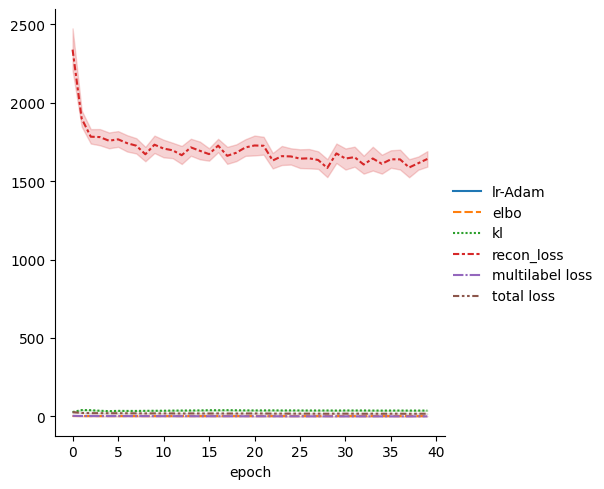

In [9]:
# training log plots
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head(400))
sn.relplot(data=metrics, kind="line")

# 4 - Plot Images

In [10]:
# plot images
def generate_image(x, y, wrong_y, model,num_predictions=25):
    figure(figsize=(8, 3), dpi=300)
    t2img = T.ToPILImage()
    cifar10_labels = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    with torch.no_grad():

        mu,log_var = model.encoder(x.to('cuda'),wrong_y.to('cuda'))

        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        x_hat = model.decoder(z,wrong_y.to('cuda'))
        fig = plt.figure(figsize=(15,15))

        for idx in np.arange(num_predictions):

          ax = fig.add_subplot(5,5,idx + 1,xticks=[],yticks=[])
          img = x_hat[idx].to('cpu')
          plt.imshow(img.permute(1,2,0))
          ax.set_title(f"Label/Image: {cifar10_labels[wrong_y[idx]]} / {cifar10_labels[y[idx]]}")

        fig.tight_layout(pad=5.0)
        plt.show()

        #img = make_grid(x_hat, nrow=8)
        #plt.imshow(t2img(make_grid(x_hat, nrow=8)), interpolation='nearest')

<Figure size 2400x900 with 0 Axes>

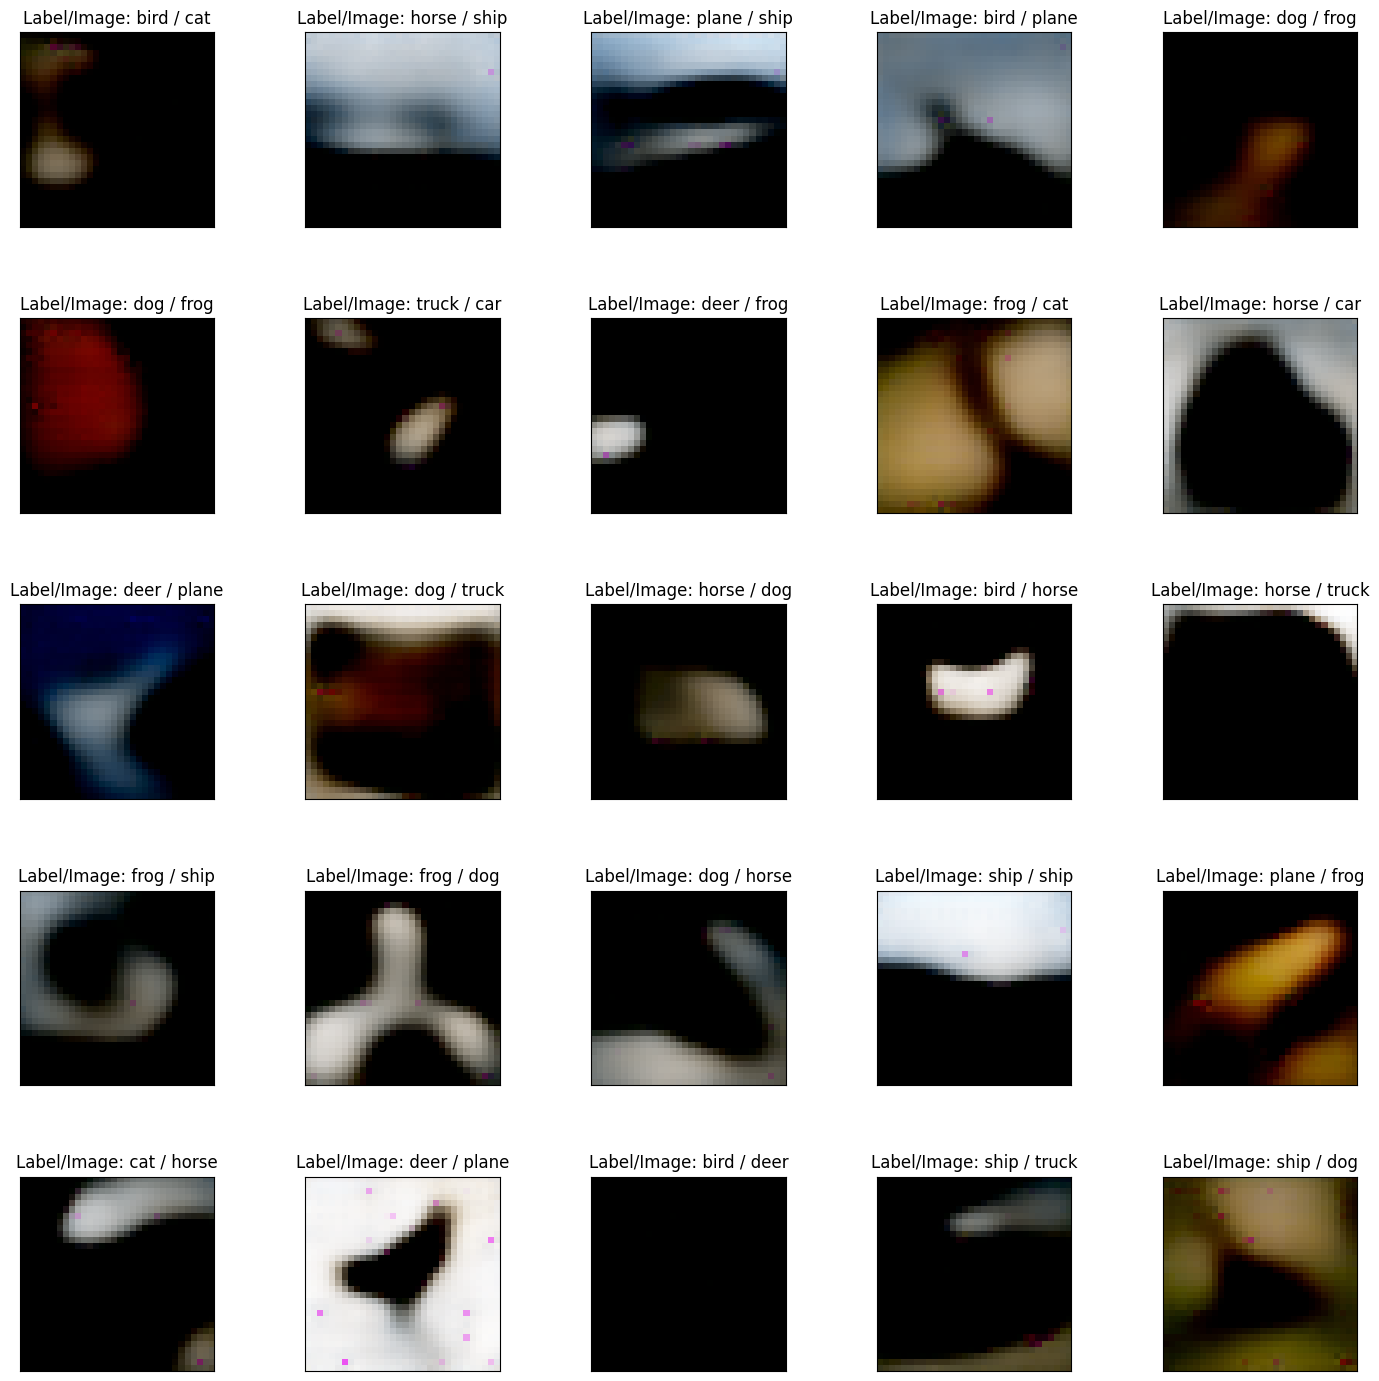

In [13]:
val_batch = next(iter(test_dataloader))
x, y, y_changed  = val_batch['image'],val_batch['correct_label'],val_batch['changed_label']
wrong_y = torch.flip(y_changed,[0])
generate_image(x,y,wrong_y,my_vae.to('cuda'))